In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os


In [2]:
merged_dir = "../../../data/merged"
image_dir = "../../../images/knn"
train_file_path = os.path.join(merged_dir, "train_smote_tomek.parquet")
train_data = pd.read_parquet(train_file_path)
test_file_path = os.path.join(merged_dir, "test_data.parquet")
test_data = pd.read_parquet(test_file_path)

In [3]:
# Prepare features and labels
X_train = train_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_train = train_data['fire'].to_numpy()

X_test = test_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_test = test_data['fire'].to_numpy()

In [4]:
import sys
from pathlib import Path

# Add the folders where the .py files live
sys.path.append(str(Path('../../../code/myModels').resolve()))
sys.path.append(str(Path('../../../code/Metrics').resolve()))

# Now import
from knn import MyKnn
from classification import ClassificationMetrics, evaluate_predictions


In [5]:
# free up memory

import gc
gc.collect()

0

In [6]:
# 1. Fit
knn = MyKnn(k=[1, 3, 5, 7, 9, 11], distance='manhattan', batch_size=1000)
knn.fit(X_train, y_train)

In [7]:
# 2. Predict for all k at once (return dict: {k: preds})
y_preds = knn.predict(X_test=X_test,k=[1, 3, 5, 7, 9, 11])

Processed train batch 0:1000 of 60102; memory: 726 KB
Processed train batch 1000:2000 of 60102; memory: 726 KB
Processed train batch 2000:3000 of 60102; memory: 726 KB
Processed train batch 3000:4000 of 60102; memory: 726 KB
Processed train batch 4000:5000 of 60102; memory: 726 KB
Processed train batch 5000:6000 of 60102; memory: 726 KB
Processed train batch 6000:7000 of 60102; memory: 726 KB
Processed train batch 7000:8000 of 60102; memory: 726 KB
Processed train batch 8000:9000 of 60102; memory: 726 KB
Processed train batch 9000:10000 of 60102; memory: 726 KB
Processed train batch 10000:11000 of 60102; memory: 726 KB
Processed train batch 11000:12000 of 60102; memory: 726 KB
Processed train batch 12000:13000 of 60102; memory: 726 KB
Processed train batch 13000:14000 of 60102; memory: 726 KB
Processed train batch 14000:15000 of 60102; memory: 726 KB
Processed train batch 15000:16000 of 60102; memory: 726 KB
Processed train batch 16000:17000 of 60102; memory: 726 KB
Processed train bat

k=1: Macro-F1=0.8308
k=3: Macro-F1=0.8057
k=5: Macro-F1=0.7938
k=7: Macro-F1=0.7806
k=9: Macro-F1=0.7740
k=11: Macro-F1=0.7663
Elbow plot saved to: ../../../images/knn\knn_smote_tomek_elbow_curve.png


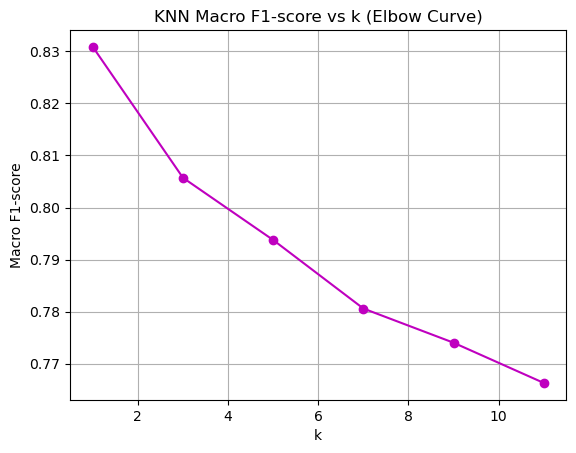

{1: 0.830837392775109,
 3: 0.8057040042875737,
 5: 0.7937594475262659,
 7: 0.7805998319517427,
 9: 0.7740357430497131,
 11: 0.7663154317298122}

In [8]:
# 3. Plot elbow using predictions 
savepath = os.path.join(image_dir, "knn_smote_tomek_elbow_curve.png")
knn.plot_elbow_curve(y_true=y_test, y_pred_dict=y_preds, savepath=savepath)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

def collect_knn_metrics_to_df(y_test, y_preds):
    """
    Collect metrics for each k into a pandas DataFrame using sklearn.
    
    Args:
        y_test: True labels for the test set
        y_preds: dict, {k: predicted_labels_for_k}
        
    Returns:
        metrics_df: pandas DataFrame with columns:
            ['k', 'accuracy', 'f1_macro', 'f1_micro', 'f1_weighted',
             'precision_macro', 'recall_macro']
    """
    records = []
    for k, y_pred in y_preds.items():
        records.append({
            'k': k,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_micro': f1_score(y_test, y_pred, average='micro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0)
        })
    
    metrics_df = pd.DataFrame(records).sort_values("k").reset_index(drop=True)
    return metrics_df

# Usage example after prediction
metrics_df = collect_knn_metrics_to_df(y_test, y_preds)
print(metrics_df)


    k  accuracy  f1_macro  f1_micro  f1_weighted  precision_macro  \
0   1  0.932853  0.830837  0.932853     0.934778         0.813307   
1   3  0.914884  0.805704  0.914884     0.920944         0.770261   
2   5  0.904126  0.793759  0.904126     0.913133         0.752149   
3   7  0.892422  0.780600  0.892422     0.904532         0.736362   
4   9  0.885684  0.774036  0.885684     0.899710         0.729063   
5  11  0.879537  0.766315  0.879537     0.895016         0.721956   

   recall_macro  
0      0.851457  
1      0.860435  
2      0.869937  
3      0.875909  
4      0.881152  
5      0.879221  


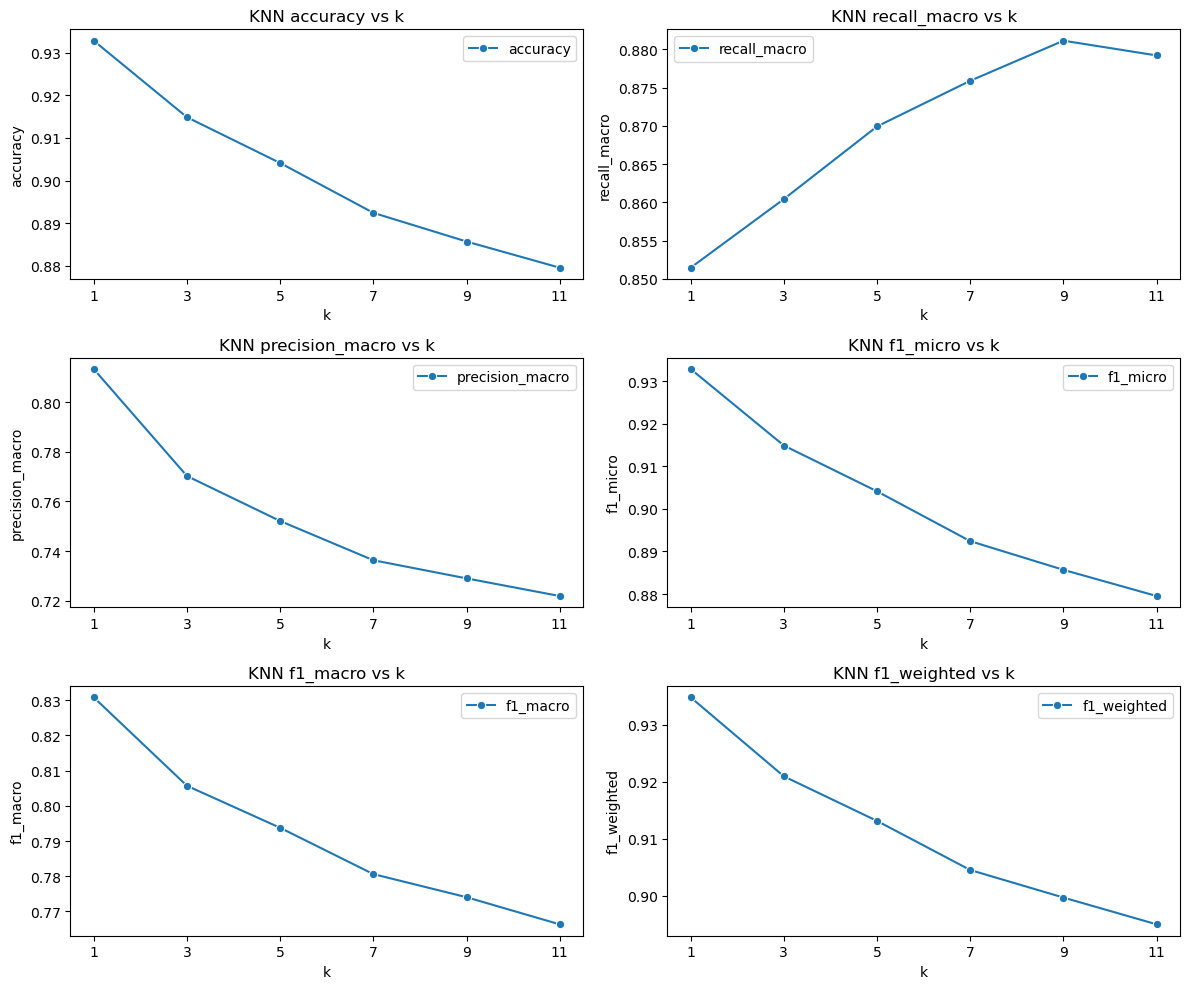

In [10]:
# plot metrics in multiple subplots for each k with legend
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()
metric_names = ['accuracy','recall_macro', 'precision_macro', 'f1_micro','f1_macro','f1_weighted']
for i, metric_name in enumerate(metric_names):
    sns.lineplot(data=metrics_df, x='k', y=metric_name, marker='o', ax=axs[i])
    axs[i].set_title(f'KNN {metric_name} vs k')
    axs[i].set_xlabel('k')
    axs[i].set_ylabel(metric_name)
    axs[i].set_xticks(metrics_df['k'])
    axs[i].legend([metric_name])
plt.tight_layout()
savepath = os.path.join(image_dir, "knn_smote_tomek_metrics_vs_k.png")
plt.savefig(savepath)
plt.show()

In [11]:
# store predictions for k=3 in csv with pred and true labels
y_pred_k3 = y_preds[3]
pred_true_df_k3 = pd.DataFrame({'predicted': y_pred_k3, 'true': y_test})
pred_true_df_k3.to_csv("knn_smote_tomek_predictions_k3.csv", index=False)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# True and predicted labels
y_true = pred_true_df_k3['true']
y_pred = pred_true_df_k3['predicted']

# 1️⃣ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = np.unique(np.concatenate([y_true, y_pred]))

# Pretty-print confusion matrix
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=labels, columns=labels))

# 2️⃣ Classification report (precision, recall, f1-score)
report = classification_report(y_true, y_pred, digits=3)
print("\nClassification Report:")
print(report)



Confusion Matrix:
      0    1
0  7040  536
1   184  699

Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.929     0.951      7576
           1      0.566     0.792     0.660       883

    accuracy                          0.915      8459
   macro avg      0.770     0.860     0.806      8459
weighted avg      0.932     0.915     0.921      8459



AUC Scores for different k values: {1: 0.851456916459081, 3: 0.860434871520125, 5: 0.8699369230603646, 7: 0.875909470330698, 9: 0.8811521542069429, 11: 0.8792210246101118}


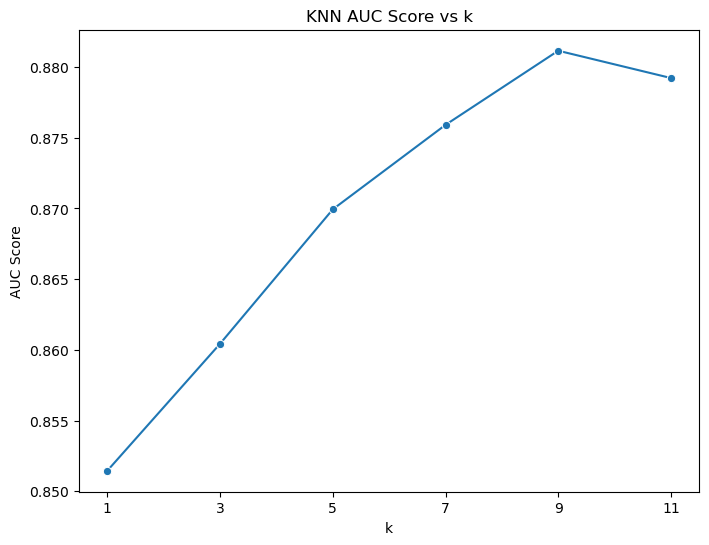

In [13]:
# calculate auc score for all k values
from sklearn.metrics import roc_auc_score
auc_scores = {}
for k, y_pred in y_preds.items():
    try:
        auc = roc_auc_score(y_test, y_pred)
    except ValueError:
        auc = np.nan  # Handle case where AUC cannot be computed
    auc_scores[k] = auc
print("AUC Scores for different k values:", auc_scores)
# plot auc scores vs k
plt.figure(figsize=(8, 6))
sns.lineplot(x=list(auc_scores.keys()), y=list(auc_scores.values()), marker='o')
plt.title('KNN AUC Score vs k')
plt.xlabel('k')
plt.ylabel('AUC Score')
plt.xticks(list(auc_scores.keys()))
savepath = os.path.join(image_dir, "knn_smote_tomek_auc_vs_k.png")
plt.savefig(savepath)
plt.show()